# Analyze RAGIS ensmbles

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path
import os
import xarray as xr

import seaborn as sns

from pism_ragis.observations import load_imbie, load_mouginot, load_mankoff, plot_observations, plot_multiple_observations
from pism_ragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pism_ragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, to_decimal_year
from pism_ragis.stats import run_stats

## Some settings

In [2]:
# Root directory
data_dir = Path("/mnt/storstrommen/ragis/data/pism")
assert data_dir.exists()
results_dir = "2024_02_ragis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)
# Number of parallel jobs
n_jobs = 4
# Normalization year (1992 IMBIE)
norm_year = 1992

In [23]:

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027",  "#4575b4", "#fc8d59", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.45"
man_color = "0.35"
mou_color = "0.25"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

## Load Observations

In [4]:
# imbie = load_imbie(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/imbie_dataset_greenland_dynamics-2020_02_28.xlsx"))
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

mou = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

man = load_mankoff(Path("/mnt/storstrommen/ragis/data/mankoff/MB_SMB_D_BMB.csv"))

/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWar

## Make a list of all experiments

In [5]:
exps = []

# exps.append({
#     "Experiment": "GrIMP",
#     "proj_dir": "2023_10_grimp_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "GRIMP"
# }
# )



# exps.append({
#     "Experiment": "RAGIS",
#     "proj_dir": "2023_10_ragis_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "RAGIS"
# }
# )

exps.append({
    "Experiment": "GrIMP",
    "proj_dir": "2024_02_grimp",
    "scalar_dir": "scalar",
    "scalar_processed_dir": "scalar_processed",
    "spatial_dir": "spatial",
    "spatial_processed_dir": "spatial_processed",
    "lhs": "gris_ragis_ctrl",
    "DEM": "GRIMP",
    "resolution": 900
}
)



exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2024_02_ragis",
    "scalar_dir": "scalar",
    "scalar_processed_dir": "scalar_processed",
    "spatial_dir": "spatial",
    "spatial_processed_dir": "spatial_processed",
    "lhs": "gris_ragis_ctrl",
    "DEM": "RAGIS",
    "resolution": 900
}
)



## Process experiments

In [46]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = data_dir / exp["proj_dir"] / "uq" /f"""{exp["lhs"]}.csv"""
    s_dir = data_dir / exp["proj_dir"] / exp["scalar_dir"]
    scalar_files = sorted(s_dir.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    processed_path = data_dir / exp["proj_dir"] / exp["scalar_processed_dir"]
    for scalar_file in scalar_files:
        if check_file(scalar_file, norm_year=1992):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(processed_path.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs, norm_year=1980)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Processing GrIMP

Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

Conversion finished in 1 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS

Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

Conversion finished in 1 seconds
-------------------------------------------
-------------------------------------------



In [7]:
spatial_vars = ["usurf", "velsurf_mag"]

In [8]:
def select_time_slice(ds,
                      start_date: str = "1985-01-01", 
                      end_date: str = "1986-01-01", 
                      variables: list = ["usurf", "velsurf_mag"]):
    return ds.sel(time=slice(start_date, end_date))

In [9]:
# for exp in exps:
#     print(f"""Processing {exp["Experiment"]}""")
#     print("================================================\n")
#     s_dir = data_dir / exp["proj_dir"] / exp["spatial_dir"]
#     spatial_files = sorted(s_dir.glob(f"""ex_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
#     ds = xr.open_mfdataset(spatial_files, preprocess=select_time_slice, combine="nested", concat_dim="id", chunks={"id": -1}, parallel=True)
#     %time ds_v = ds[spatial_vars].mean(dim="time")
#     %time ensmedian = ds_v.quantile(50, "id")



## Ensemble Performance Statistics

In [10]:
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m, e in enumerate(experiments):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {e["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

Peformace Summary for Experiment GrIMP (3 members)
---------------------------------------------------

processor_hours                   9496.951057
wall_clock_hours                    79.141259
model_years_per_processor_hour       0.013230
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (3 members)
---------------------------------------------------

processor_hours                   12094.488762
wall_clock_hours                    100.787406
model_years_per_processor_hour        0.011678
dtype: float64
---------------------------------------------------



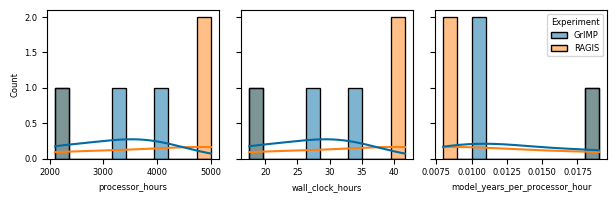

In [11]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
run_stats_file = fig_dir / "run_stats.pdf"
fig.savefig(run_stats_file)

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

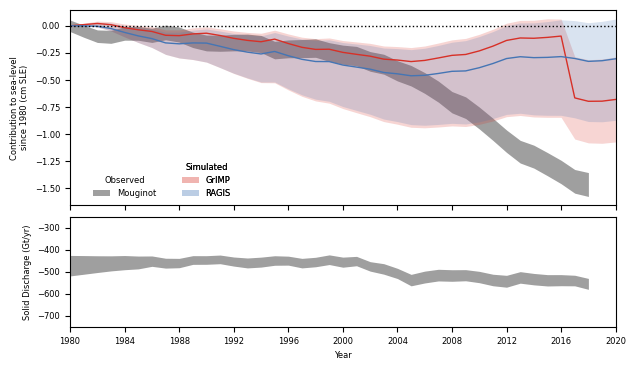

In [30]:
sigma_mass = 1 
sigma_discharge = 2

plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot"], 
                                       [mou_color], [(0.1, 0.0)], [0.5]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)


legend_obs = axs[0].legend(loc="lower center", bbox_to_anchor=obs_loc, title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.25, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
# axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

{'Experiment': 'GrIMP',
 'proj_dir': '2024_02_grimp',
 'scalar_dir': 'scalar',
 'scalar_processed_dir': 'scalar_processed',
 'spatial_dir': 'spatial',
 'spatial_processed_dir': 'spatial_processed',
 'lhs': 'gris_ragis_ctrl',
 'DEM': 'GRIMP',
 'resolution': 900,
 'data_df':           time                   id  basal_mass_flux_floating (Gt year-1)  \
 0   1980-01-01         BAYES-MEDIAN                           -363.909111   
 1   1980-01-01      BAYES-MEDIAN-FR                           -342.390347   
 2   1980-01-01  BAYES-MEDIAN-FR-OFF                             -0.243835   
 3   1981-01-01         BAYES-MEDIAN                           -264.515843   
 4   1981-01-01      BAYES-MEDIAN-FR                           -235.090677   
 ..         ...                  ...                                   ...   
 114 2018-01-01  BAYES-MEDIAN-FR-OFF                             -0.303023   
 115 2019-01-01         BAYES-MEDIAN                           -122.191317   
 116 2019-01-01  BAYES-ME

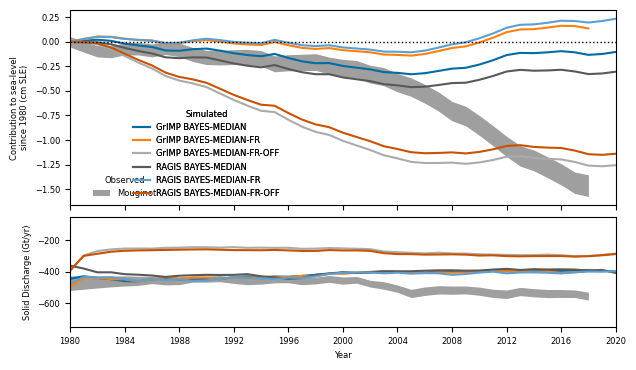

In [84]:
sigma_mass = 1 
sigma_discharge = 2


plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot"], 
                                       [mou_color], [(0.1, 0.0)], [0.5]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)


legend_obs = axs[0].legend(loc="lower center", bbox_to_anchor=obs_loc, title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    for m_id, id_df in df.groupby(by="id"):
        sims_line = axs[0].plot(id_df["time"], id_df[mass_varname], label=exp["Experiment"] + " " + m_id)
        sims_lines.append(sims_line[0])
        axs[1].plot(id_df["time"], -id_df[discharge_varname], label=exp["Experiment"] + " " + m_id)
if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_lines, loc="lower center", bbox_to_anchor=[0.25, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
# axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(-750, -50)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

In [82]:
id_df

,time,id,basal_mass_flux_floating (Gt year-1),basal_mass_flux_grounded (Gt year-1),dt (year),dt_ratio (1),grounding_line_flux (Gt year-1),ice_area_glacierized (m2),ice_area_glacierized_cold_base (m2),ice_area_glacierized_floating (m2),...,tendency_of_ice_mass_glacierized (Gt year-1),tendency_of_ice_volume (m3 year-1),tendency_of_ice_volume_glacierized (m3 year-1),Year,resolution_m,Cumulative ice sheet mass change (Gt),SLE (cm),Rate of ice discharge (Gt/yr),Rate of surface mass balance (Gt/yr),Experiment
2,1980-01-01,BAYES-MEDIAN-FR-OFF,-0.235761,-11.090429,0.001372,26.783703,-391.123123,1.646640e+12,9.379792e+11,4.875878e+09,...,-357.530161,-3.859140e+11,-3.928903e+11,1980.0,900,0.000000,0.000000,391.123123,510.397584,RAGIS
5,1981-01-01,BAYES-MEDIAN-FR-OFF,-0.250413,-9.955705,0.001378,26.145650,-299.051119,1.647355e+12,9.382420e+11,5.208218e+09,...,13.086422,2.067742e+10,1.438068e+10,1981.0,900,2.397690,-0.000661,299.051119,421.096049,RAGIS
8,1982-01-01,BAYES-MEDIAN-FR-OFF,-0.259038,-9.587483,0.001400,31.497499,-285.479808,1.648527e+12,9.394309e+11,5.406830e+09,...,51.831997,6.404164e+10,5.695824e+10,1982.0,900,55.572895,-0.015330,285.479808,423.326841,RAGIS
11,1983-01-01,BAYES-MEDIAN-FR-OFF,-0.266206,-9.493441,0.001409,29.051406,-272.442316,1.650020e+12,9.404448e+11,5.553921e+09,...,234.449385,2.649366e+11,2.576367e+11,1983.0,900,208.127109,-0.057414,272.442316,593.296430,RAGIS
14,1984-01-01,BAYES-MEDIAN-FR-OFF,-0.270922,-9.416367,0.001403,29.083311,-266.413264,1.652040e+12,9.425910e+11,5.660596e+09,...,245.826602,2.739687e+11,2.701391e+11,1984.0,900,440.307634,-0.121464,266.413264,590.221002,RAGIS
17,1985-01-01,BAYES-MEDIAN-FR-OFF,-0.274767,-9.420848,0.001408,27.376447,-264.159291,1.654642e+12,9.449733e+11,5.744340e+09,...,136.989639,1.457223e+11,1.505381e+11,1985.0,900,665.303578,-0.183532,264.159291,465.587838,RAGIS
20,1986-01-01,BAYES-MEDIAN-FR-OFF,-0.277627,-9.407591,0.001428,24.926743,-262.813104,1.656545e+12,9.467018e+11,5.810026e+09,...,255.821672,2.778018e+11,2.811227e+11,1986.0,900,870.109752,-0.240030,262.813104,589.115515,RAGIS
23,1987-01-01,BAYES-MEDIAN-FR-OFF,-0.279916,-9.369003,0.001427,24.609406,-260.907893,1.658429e+12,9.483547e+11,5.864753e+09,...,229.250159,2.455047e+11,2.519233e+11,1987.0,900,1135.249643,-0.313172,260.907893,554.974542,RAGIS
26,1988-01-01,BAYES-MEDIAN-FR-OFF,-0.283154,-9.405285,0.001458,23.998850,-259.424435,1.659432e+12,9.499420e+11,5.940190e+09,...,157.584166,1.679093e+11,1.731694e+11,1988.0,900,1294.866112,-0.357204,259.424435,481.914759,RAGIS
29,1989-01-01,BAYES-MEDIAN-FR-OFF,-0.286079,-9.379855,0.001456,23.409955,-258.058170,1.660170e+12,9.503425e+11,6.003900e+09,...,98.305556,1.040262e+11,1.080281e+11,1989.0,900,1387.005771,-0.382622,258.058170,414.500625,RAGIS


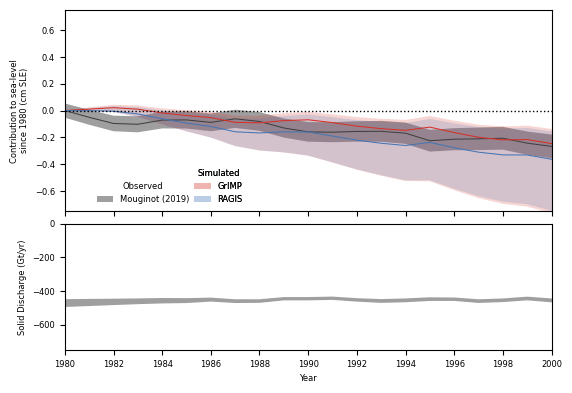

In [15]:
plt.rc('font', size=10)
plt.style.use("tableau-colorblind10")

sigma_mass = 1
sigma_discharge = 1
plot_experiments = [experiments[-2], experiments[-1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4), height_ratios=[16, 10])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.05, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
        axs[0].plot(obs["Date"], obs[mass_varname], lw=0.75, color=obs_color)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower left", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_low = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_median = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_high = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_median.index, q_median[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_median.index, q_median[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_low.index, q_low[mass_varname], 
                        q_high[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_low.index, q_low[discharge_varname], 
                        q_high[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower left", bbox_to_anchor=[0.25, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-0.75, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.png", dpi=600)

In [16]:
mou_gis

,Year,Cumulative ice sheet mass change (Gt),Cumulative surface mass balance anomaly (Gt),Cumulative ice discharge anomaly (Gt),Cumulative ice sheet mass change uncertainty (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of ice sheet mass change (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Date,SLE (cm),SLE uncertainty (cm),Basin
0,1972.0,-285.871918,-689.888667,398.186748,69.468048,55.400612,41.911595,48.799409,501.71,-452.910591,69.468048,55.400612,41.911595,1972-01-01,-0.078861,-0.019164,GIS
1,1973.0,-142.008513,-503.011333,355.922821,96.893498,78.348297,57.007844,143.863406,596.77,-452.906594,67.546579,55.400612,38.643402,1973-01-01,-0.039175,-0.026729,GIS
2,1974.0,-120.895608,-438.414000,313.248392,117.176457,95.956675,67.250565,21.112904,474.43,-453.317096,65.893642,55.400612,35.675541,1974-01-01,-0.033351,-0.032325,GIS
3,1975.0,-165.175719,-437.926667,269.400948,133.753184,110.801225,74.919976,-44.280111,410.21,-454.490111,64.494899,55.400612,33.020663,1975-01-01,-0.045566,-0.036897,GIS
4,1976.0,-128.103564,-354.449333,223.315769,148.005344,123.879535,80.990386,37.072155,493.80,-456.727845,63.369296,55.400612,30.764263,1976-01-01,-0.035339,-0.040829,GIS
5,1977.0,-1.372245,-177.012000,173.369755,160.651420,135.703232,85.985533,126.731319,587.32,-460.588681,62.476372,55.400612,28.880256,1977-01-01,-0.000379,-0.044318,GIS
6,1978.0,19.678810,-101.054667,119.503477,172.095123,146.576243,90.178359,21.051055,485.56,-464.508945,61.707799,55.400612,27.177649,1978-01-01,0.005429,-0.047475,GIS
7,1979.0,40.180091,-21.967333,61.697424,182.545060,156.696595,93.642278,20.501280,488.95,-468.448720,60.876658,55.400612,25.233702,1979-01-01,0.011084,-0.050357,GIS
8,1980.0,0.000000,0.000000,0.000000,192.184516,166.201837,96.497864,-40.180091,432.16,-472.340091,60.101493,55.400612,23.301536,1980-01-01,0.000000,-0.053016,GIS
9,1981.0,-182.131191,-124.752667,-58.188525,201.131982,175.192119,98.801801,-182.131191,286.70,-468.831191,59.322728,55.400612,21.212218,1981-01-01,-0.050243,-0.055485,GIS


            basal_mass_flux_floating (Gt year-1)  \
time                                               
1980-01-01                           -342.390347   
1981-01-01                           -235.090677   
1982-01-01                           -190.305958   
1983-01-01                           -185.853639   
1984-01-01                           -176.065273   
1985-01-01                           -164.193813   
1986-01-01                           -150.695956   
1987-01-01                           -143.698489   
1988-01-01                           -141.680096   
1989-01-01                           -136.650172   
1990-01-01                           -132.947961   
1991-01-01                           -131.685499   
1992-01-01                           -131.367216   
1993-01-01                           -124.819710   
1994-01-01                           -116.897214   
1995-01-01                           -110.877244   
1996-01-01                           -108.098542   
1997-01-01  

KeyError: 'Cumulative ice discharge anomaly (Gt)'

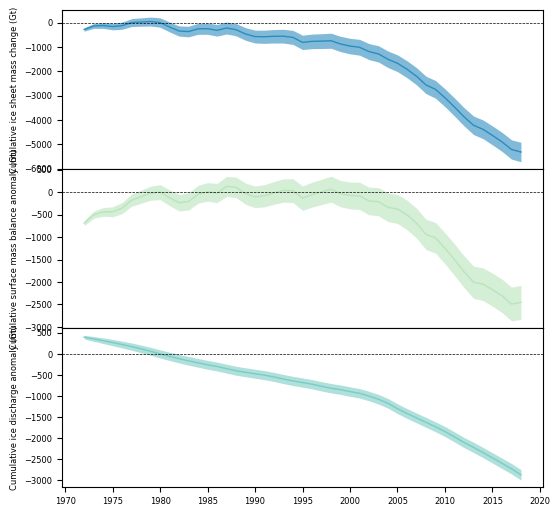

In [17]:
    sigma = 1
    mass_varname: str = "Cumulative ice sheet mass change (Gt)"
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)"
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)"
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)"
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)"
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)"
    smb_color: str = "#bae4bc"
    discharge_color: str = "#7bccc4"
    mass_color: str = "#2b8cbe"

    obs = mou_gis
    
    """Plot observation time series"""
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 6.2))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for k, (m_var, m_u_var, m_color, m_label) in enumerate(zip(
        [mass_varname, smb_varname, discharge_varname],
        [
            mass_uncertainty_varname,
            smb_uncertainty_varname,
            discharge_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    )):

        axs[k].fill_between(
            obs["Date"],
            obs[m_var] + sigma * obs[m_u_var],
            obs[m_var] - sigma * obs[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[k].plot(obs["Date"], obs[m_var], lw=1, color=m_color, label=m_label)
        axs[k].set_ylabel(m_var)
        axs[k].axhline(0, ls="dashed", color="k", lw=0.5)
        
    sims_cis = []
    sims_lines = []
    for e, exp in enumerate(plot_experiments):
        df = exp["data_df"]
        q_low = df.groupby(by="time").quantile(0.16, numeric_only=True)
        q_median = df.groupby(by="time").quantile(0.50, numeric_only=True)
        print(q_median)
        q_high = df.groupby(by="time").quantile(0.84, numeric_only=True)
        sims_line = axs[k].plot(q_median.index, q_median[m_var], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

    axs[0].set_xlabel("")
    axs[-1].set_xlabel("Year")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    fig.tight_layout()


In [ ]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 1
sigma_smb = 1
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    axs[2].fill_between(q_16.index, q_16[smb_varname], 
                        q_84[smb_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Ice Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

## Plot sensitivity index

In [ ]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["DEM"]}_{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    o_file = fig_dir / f"{si}_{outfile}"
    fig.savefig(o_file)
    !open o_file

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
xr.open_mfdataset?

In [ ]:
df

In [ ]:
load_mankoff?